In [4]:
## Install required packages -- run on first run
# !pip install -r requirements.txt

In [1]:
import os
import shutil

import numpy as np
import torch
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from importlib import reload

from examples.sentence_level.wmt_2020.common.util.draw import draw_scatterplot, print_stat
from examples.sentence_level.wmt_2020.common.util.normalizer import fit, un_fit
from examples.sentence_level.wmt_2020.common.util.postprocess import format_submission
from reader import read_annotated_file, read_test_file
from examples.sentence_level.wmt_2020.en_de.monotransquest_config import TEMP_DIRECTORY, MODEL_NAME, \
    monotransquest_config, MODEL_TYPE, SEED, RESULT_FILE, RESULT_IMAGE, SUBMISSION_FILE
from transquest.algo.sentence_level.monotransquest.evaluation import pearson_corr, spearman_corr
from run_model_mcdropoutv2 import MonoTransQuestModel
# from transquest.algo.sentence_level.monotransquest.run_model import MonoTransQuestModel

if not os.path.exists(TEMP_DIRECTORY):
    os.makedirs(TEMP_DIRECTORY)

TRAIN_FILE = "examples/sentence_level/wmt_2020/en_de/data/en-de/train.ende.df.short.tsv"
DEV_FILE = "examples/sentence_level/wmt_2020/en_de/data/en-de/dev.ende.df.short.tsv"
TEST_FILE = "examples/sentence_level/wmt_2020/en_de/data/en-de/test20.ende.df.short.tsv"


 
train_all= read_annotated_file(TRAIN_FILE)
#train=train_all[train_all.score_stds < np.percentile(train_all.score_stds,95)]
#train_10=train_all[(train_all.score_stds >np.percentile(train_all.score_stds,45)) & (train_all.score_stds <np.percentile(train_all.score_stds,55))]
#train_add=train_all[(train_all.score_stds >np.percentile(train_all.score_stds,45)) & (train_all.score_stds <np.percentile(train_all.score_stds,55))]
#train=pd.concat([train_all,train_add],axis=0)
train=train_all
dev = read_annotated_file(DEV_FILE)
test = read_test_file(TEST_FILE)

train = train[['original', 'translation', 'z_mean']]
dev = dev[['original', 'translation', 'z_mean']]
test = test[['index', 'original', 'translation']]

index = test['index'].to_list()
train = train.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
dev = dev.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
test = test.rename(columns={'original': 'text_a', 'translation': 'text_b'}).dropna()

test_sentence_pairs = list(map(list, zip(test['text_a'].to_list(), test['text_b'].to_list())))

train = fit(train, 'labels')
dev = fit(dev, 'labels')

In [2]:
train.shape

(7000, 3)

In [3]:
MODEL_TYPE = "xlmroberta"
MODEL_NAME = "xlm-roberta-base"

monotransquest_config["num_train_epochs"] = 5
monotransquest_config["n_fold"] = 1
monotransquest_config["evaluate_during_training"]=False
monotransquest_config["save_best_model"]= False
monotransquest_config["save_eval_checkpoints"]= False
monotransquest_config["save_optimizer_and_scheduler"]= False
monotransquest_config["train_batch_size"]= 16
 
assert (len(index) == 1000)
print (torch.cuda.is_available())
model = MonoTransQuestModel(MODEL_TYPE, MODEL_NAME, num_labels=1, use_cuda=torch.cuda.is_available(),
                            args=monotransquest_config)

True


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.b

In [4]:
model.train_model(train, pearson_corr=pearson_corr, spearman_corr=spearman_corr, mae=mean_absolute_error)

  0%|          | 0/7000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/438 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/438 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/438 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/438 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/438 [00:00<?, ?it/s]

(2190, 0.018799895062919316)

In [17]:
# changing dropout probability
model.config.hidden_dropout_prob = 0.01

In [6]:
# print(model.config)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

[[1.         0.40455407]
 [0.40455407 1.        ]]
RMSE=0.7317
MAE=0.6025
Pearson Correlation=0.4046
Spearman Correlation=0.4277


<Figure size 432x288 with 0 Axes>

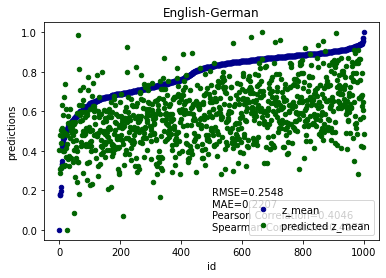

In [6]:
# Applying MC dropout by setting dropout layer to train mode
# https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571
result, model_outputs, wrong_predictions = model.eval_model(dev, pearson_corr=pearson_corr,
                                                            spearman_corr=spearman_corr, mae=mean_absolute_error)

# print(np.corrcoef(dev.labels, model_outputs))
# predictions, raw_outputs = model.predict(test_sentence_pairs)
dev['predictions'] = model_outputs
# test['predictions'] = predictions
###############################
dev = un_fit(dev, 'labels')
dev = un_fit(dev, 'predictions')
# test = un_fit(test, 'predictions')
#dev.to_csv(os.path.join(TEMP_DIRECTORY, RESULT_FILE), header=True, sep='\t', index=False, encoding='utf-8')
draw_scatterplot(dev, 'labels', 'predictions', os.path.join(TEMP_DIRECTORY, RESULT_IMAGE), "English-German")
print_stat(dev, 'labels', 'predictions')
#format_submission(df=test, index=index, language_pair="en-zh", method="TransQuest",
#                  path=os.path.join(TEMP_DIRECTORY, SUBMISSION_FILE))

#RMSE=0.9626
#MAE=0.7742
#Pearson Correlation=0.4357
#Spearman Correlation=0.4295

#RMSE=1.0433
#MAE=0.8532
#Pearson Correlation=0.3142
#Spearman Correlation=0.3199

#roberta base 1 -1 roberta base
#RMSE=1.1795
#MAE=1.0022
#Pearson Correlation=0.3893
#Spearman Correlation=0.3789

#train_add=train[(train.score_stds >np.percentile(train.score_stds,45)) & (train.score_stds <np.percentile(train.score_stds,55))]
#RMSE=1.0423
#MAE=0.8575
#Pearson Correlation=0.4327
#Spearman Correlation=0.4277

# xlm-roberta-base
# RMSE=0.0731
# MAE=0.0544
# Pearson Correlation=0.2348
# Spearman Correlation=0.2931

# xlm-roberta-base with train mode



  0%|          | 0/1000 [00:00<?, ?it/s]

Forward pass: 0


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 1


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 2


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 3


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 4


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 5


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 6


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 7


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 8


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Forward pass: 9


Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


[[1.         0.17037044]
 [0.17037044 1.        ]]
RMSE=0.0000
MAE=0.0000
Pearson Correlation=0.1704
Spearman Correlation=0.1764


<Figure size 432x288 with 0 Axes>

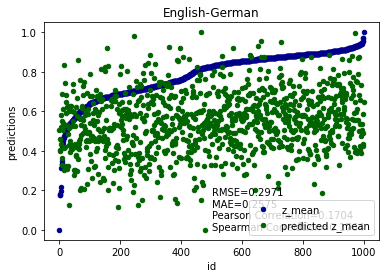

In [18]:
# Applying MC dropout by setting dropout layer to train mode
# https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571
result, model_outputs, wrong_predictions = model.eval_model_mcdropout(dev, pearson_corr=pearson_corr,
                                                            spearman_corr=spearman_corr, mae=mean_absolute_error)

print(np.corrcoef(dev.labels, model_outputs))
# predictions, raw_outputs = model.predict(test_sentence_pairs)
dev['predictions'] = model_outputs
# test['predictions'] = predictions
###############################
dev = un_fit(dev, 'labels')
dev = un_fit(dev, 'predictions')
# test = un_fit(test, 'predictions')
#dev.to_csv(os.path.join(TEMP_DIRECTORY, RESULT_FILE), header=True, sep='\t', index=False, encoding='utf-8')
draw_scatterplot(dev, 'labels', 'predictions', os.path.join(TEMP_DIRECTORY, RESULT_IMAGE), "English-German")
print_stat(dev, 'labels', 'predictions')


In [16]:
test_sentence_pairs

[['The Sultan appoints judges, and can grant pardons and commute sentences.',
  'Der Sultan ernennt Richter und kann Begnadigungen und Pendelstrafen gewähren.'],
 ['Antisemitism in modern Ukraine Antisemitism and Special Relativity',
  'Antisemitismus in der modernen Ukraine Antisemitismus und besondere Relativität'],
 ['Morales continued his feud with Buddy Rose, defeating him by disqualification.',
  'Morales setzte seine Fehde mit Buddy Rose fort und besiegte ihn durch Disqualifikation.'],
 ['American Maury Tripp attended the Jamboree from Saratoga, California.',
  'Der Amerikaner Maury Tripp besuchte das Jamboree aus Saratoga, Kalifornien.'],
 ['He bowled a series of bouncers at Viv Richards at Brisbane and claimed 3/77 and 5/92 in the Third Test at Melbourne.',
  'Er boomte eine Reihe von Bouncern bei Viv Richards in Brisbane und behauptete 3 / 77 und 5 / 92 im dritten Test in Melbourne.'],
 ["The Frenchwoman's win irritated some of her male rivals.",
  'Der Sieg der Französin irr

In [14]:
print(model.args)

MonoTransQuestArgs(adam_epsilon=1e-08, best_model_dir='temp/outputs/best_model', cache_dir='temp/cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=10, encoding=None, adafactor_eps=(1e-30, 0.001), adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_beta1=None, adafactor_scale_parameter=True, adafactor_relative_step=True, adafactor_warmup_init=True, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300, evaluate_during_training_verbose=True, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=1e-05, local_rank=-1, logging_steps=300, manual_seed=777, max_grad_norm=1.0, max_seq_length=128, 